# infoGAN

## GAN
$$L_D^{GAN} = E[log(D(x))] + E[log(1 - D(G(z))]$$

$$L_G^{GAN} = E[log(D(G(z)))]$$

### infoGAN

$$L_{D,Q}^{infoGAN} = L_{D}^{GAN} - \lambda L_1(c, c')$$

$$L_{G}^{infoGAN} = L_G^{GAN} - \lambda L_1(c, c')$$

## 핵심 아이디어
- Latent Vector $z$는 Data를 Generation하는 아주 **기본적인 요소**들을 담당하게 설정
- Latent Code $c$는 Data의 **의미론적인 Feature로서 역할**을 할 수 있게 설정하여 학습하고 $c$로부터 Generation된 Data간의 **Mutual Information이 최대**가 되도록 학습

## Mutual Information
1. **엔트로피**
$$H(X) = - \sum p(x) \text{log}(p(x))$$<br>

2. **Conditional Entropy**
$$H(X|Y) = E_{y,x} [-\text{log}(p(x|y))]$$<br>

3. **Mutual Information(상호정보량)**
$$I(X; Y) = H(X) - H(X|Y)$$<br>


- **상호 정보량**은 X만 알 때의 불확실성이, Y를 알게 됨으로써 사라지는 정도로 이해할 수 있음. 
    - Y와 X가 서로 관계가 없다면 $H(X|Y)$는 $H(X)$의 차이는 없기 때문에 상호정보량은 **감소하게** 됨. 
    - Y와 X가 서로 관계가 높다면 $H(X|Y)$, Y를 알 때의 X의 불확실성이 크게 감소하기 떄문에 상호정보량이 **커지게** 됨.

## infoGAN의 $\lambda I(c; G(z, c))$에 대한 이해
- Latent Code가 들어갔을 때 생성되는 Generated Data가 서로 간의 **상호 정보량이** 최대화가 되도록 GAN을 학습하는 것

### 수식전개
$$I(c; G(z, c)) = H(c) - H(c|G(z, c))$$

$$= H(c) - ( - E_{x \sim G(z, c)} [E_{c' \sim P(c|x)} [\text{log}P(c'|x)]])$$ 

### Variational Mutual Information Maximization
- P(c|x)를 알 수 없기 때문에 Q Network를 가정할 경우 아래와 같은 수식

$$\lambda L_1(c, c') = H(c) + E_{x \sim G(z, c)} [E_{c' \sim P(c|x)} [\text{log}(Q(c'|x)) + D_{KL}(P|Q)]]$$

- KL-Divergence Term은 항상 양수가 되므로 무시가 가능하기 때문에 아래와 같이 변경
$$\ge H(c) + E_{x \sim G(z, c)} [E_{c' \sim P(c|x)} [\text{log}(Q(c'|x))]]$$


- law of total expectation을 사용하여 아래와 같은 수식으로 변경
$$= H(c) + E_{x \sim G(z, c), c \sim P(c)} [\text{log}(Q(c|x))]$$

확률분포 $p(c)$로부터 $c$얻어서 Generator를 통과시켜 나온 $x$가 있을 경우 이것이 Q Network를 통과했을 경우 $c$의 Maximum Likelihood라는 것이고, Latent Code c의 복원도차를 최소화하는 것으로 결론을 내릴 수 있음

### 목적함수 이해
$$L_{D,Q}^{infoGAN} = L_{D}^{GAN} - \lambda L_1(c, c')$$

$$L_{G}^{infoGAN} = L_G^{GAN} - \lambda L_1(c, c')$$

## Latent Code C의 적용
Semantic Feature를 Class, Continuous한 값에 따라서 적용하는 방법이 다름
- **Category Code인 경우** : One-hot으로 사용하여 Cross Entropy한 방법으로 복원 오차를 구함
- **Contious Code인 경우** : Uniform, Gaussian Distribution으로 넣어주고 복원된 C를 갖고 Monte-Carlo방법으로  estimation한 확률분포 사이의 Continous Error Measurement를 하면 됨

## 1. Import Libs

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid

import gzip
import itertools
import time
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

True


## 2. Setting Hyperparameters & dir

In [2]:
num_epochs = 30
learning_rate = 0.0002
batch_size = 64
# img_size = 64
z_dim = 62
y_dim = 10
sample_num = 100
beta1 = 0.5
beta2 = 0.999
SUPERVISED = True
len_discrete_code = 10 # categorical distribution (label)
len_continuous_code = 2 # gaussian distribution (rotation, thickness)

result_dir = './save_results/MNIST/INFOGAN'
result_dir_2 = './save_results/MNIST/INFOGAN_cont'
model_dir = './save_models/MNIST/INFOGAN'

if not os.path.exists(result_dir):
    os.mkdir(result_dir)
if not os.path.exists(result_dir_2):
    os.mkdir(result_dir_2)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

## 3. Load dataset

In [3]:
def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)
    
    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

In [4]:
data_X, data_Y = load_mnist("MNIST")
print(data_X.size())
print(data_Y.size())
print(data_X.__getitem__(11).size())

torch.Size([70000, 1, 28, 28])
torch.Size([70000, 10])
torch.Size([1, 28, 28])


## 4. Build Models
### 4.1 Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim):
        super(Generator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim + 12 # label(0~9) + rotation + thickness
        self.output_dim = output_dim
        
        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.BatchNorm1d(128 * (self.input_height // 4) * (self.input_width // 4)),
            nn.ReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Sigmoid(),
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x, cont_code, dist_code):
        x = torch.cat([x, cont_code, dist_code], 1)
        x = self.fc(x)
        x = x.view(-1, 128, (self.input_height // 4), (self.input_width // 4))
        x = self.deconv(x)
        return x

### 4.2 Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_height, input_width, input_dim, output_dim, len_discrete_code, len_continuous_code):
        super(Discriminator, self).__init__()
        self.input_height = input_height
        self.input_width = input_width
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.len_discrete_code = len_discrete_code
        self.len_continuous_code = len_continuous_code
        
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_height // 4) * (self.input_width // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim + self.len_continuous_code + self.len_discrete_code),
            nn.Sigmoid()
        )
        
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.02)
                m.bias.data.zero_()
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128 * (self.input_height // 4) * (self.input_width // 4))
        x = self.fc(x)
        a = F.sigmoid(x[:, self.output_dim])
        b = x[:, self.output_dim:self.output_dim + self.len_continuous_code]
        c = x[:, self.output_dim + self.len_continuous_code:]
        return a, b, c

## util

In [7]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['d_loss']))

    y1 = hist['d_loss']
    y2 = hist['g_loss']

    plt.plot(x, y1, label='d_loss')
    plt.plot(x, y2, label='g_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

## 5. Models & Optimizers
- BCE
- CE
- MSE

In [8]:
G = Generator(28, 28, z_dim, 1)
D = Discriminator(28, 28, 1, 1, len_discrete_code, len_continuous_code)
G.initialize_weights()
D.initialize_weights()

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate, betas=(beta1, beta2))
info_optimizer = optim.Adam(itertools.chain(G.parameters(), D.parameters()), lr=learning_rate, betas=(beta1, beta2))

BCE_loss = nn.BCELoss()
CE_loss = nn.CrossEntropyLoss()
MSE_loss = nn.MSELoss()

# fix noise & condition
sample_z = torch.zeros((sample_num, z_dim))
for i in range(10):
    sample_z[i * y_dim] = torch.rand(1, z_dim)
    for j in range(1, y_dim):
        sample_z[i * y_dim + j] = sample_z[i * y_dim]

temp = torch.zeros((10, 1))
for i in range(y_dim):
    temp[i, 0] = i
    
temp_y = torch.zeros((sample_num, 1))
for i in range(10):
    temp_y[i*y_dim:(i+1)*y_dim] = temp
    
sample_y = torch.zeros((sample_num, y_dim))
sample_y.scatter_(1, temp_y.type(torch.LongTensor), 1)
sample_c = torch.zeros((sample_num, len_continuous_code))


# manipulating two continuous code
temp_z = torch.rand((1, z_dim))
sample_z2 = temp_z
for i in range(sample_num - 1):
    sample_z2 = torch.cat([sample_z2, temp_z])
    
y = np.zeros(sample_num, dtype=np.int64)
y_one_hot = np.zeros((sample_num, len_discrete_code))
y_one_hot[np.arange(sample_num), y] = 1
sample_y2 = torch.from_numpy(y_one_hot).type(torch.FloatTensor)

temp_c = torch.linspace(-1, 1, 10)
sample_c2 = torch.zeros((sample_num, 2))
for i in range(10):
    for j in range(10):
        sample_c2[i*10+j, 0] = temp_c[i]
        sample_c2[i*10+j, 1] = temp_c[j]

if USE_CUDA:
    G = G.cuda()
    D = D.cuda()
    sample_z = sample_z.cuda()
    sample_y = sample_y.cuda()
    sample_c = sample_c.cuda()
    sample_z2 = sample_z2.cuda()
    sample_y2 = sample_y2.cuda()
    sample_c2 = sample_c2.cuda()

## 6. Load model

In [9]:
try:
    G.load_state_dict(torch.load(model_dir + '/infogan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/infogan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 7. Train

$$L_{D,Q}^{infoGAN} = L_{D}^{GAN} - \lambda L_1(c, c')$$

$$L_{G}^{infoGAN} = L_G^{GAN} - \lambda L_1(c, c')$$

In [10]:
train_hist = {}
train_hist['d_loss'] = []
train_hist['g_loss'] = []
train_hist['info_loss'] = []
train_hist['per_epoch_time'] = []
train_hist['total_time'] = []

real_labels = torch.ones(batch_size, 1)
fake_labels = torch.zeros(batch_size, 1)

if USE_CUDA:
    real_labels = real_labels.cuda()
    fake_labels = fake_labels.cuda()

In [11]:
D.train()
print('training start!!!')
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    G.train()
    epoch_start_time = time.time()
    for iter in range(len(data_X) // batch_size):
        images = data_X[iter*batch_size:(iter+1)*batch_size]
        z = torch.rand((batch_size, z_dim))
        
        if SUPERVISED:
            y_disc = data_Y[iter*batch_size:(iter+1)*batch_size]
        else:
            y_disc = torch.from_numpy(
                np.random.multinomial(1, len_discrete_code * [float(1.0 / len_discrete_code)],
                                     size=[batch_size])).type(torch.FloatTensor)
        #print(y_disc_) # 64 x 10
        
        y_cont = torch.from_numpy(np.random.uniform(-1, 1, size=(batch_size, 2))).type(torch.FloatTensor)
        #print(y_cont_) # 64 x 2
        
        if USE_CUDA:
            images = images.cuda()
            z = z.cuda()
            y_disc = y_disc.cuda()
            y_cont = y_cont.cuda()
        
        d_optimizer.zero_grad()
        
        #============= Train the discriminator =============#
        # Update D network
        d_real, _, _ = D(images)
        #print(D_real) # 64
        
        d_loss_real = BCE_loss(d_real, real_labels)
        
        fake_images = G(z, y_cont, y_disc)
        d_fake, _, _ = D(fake_images)
        d_loss_fake = BCE_loss(d_fake, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        train_hist['d_loss'].append(d_loss.item())
        
        d_loss.backward(retain_graph=True)
        d_optimizer.step()
        
        #=============== Train the generator ===============#
        # Update G network
        g_optimizer.zero_grad()
        
        fake_images = G(z, y_cont, y_disc)
        d_fake, d_cont, d_disc = D(fake_images)
        
        g_loss = BCE_loss(d_fake, real_labels)
        train_hist['g_loss'].append(g_loss.item())
        
        g_loss.backward(retain_graph=True)
        g_optimizer.step()
        
        ## information loss
        disc_loss = CE_loss(d_disc, torch.max(y_disc, 1)[1])
        cont_loss = MSE_loss(d_cont, y_cont)
        info_loss = disc_loss + cont_loss
        train_hist['info_loss'].append(info_loss.item())
        
        info_loss.backward()
        info_optimizer.step() # itertools
        
        if ((iter + 1) % 100) == 0:
            print('Epoch [%d/%d], Step [%d/%d], D_loss: %.4f, G_loss: %.4f'%(epoch, num_epochs, (iter + 1), len(data_X) // batch_size, d_loss.item(), g_loss.item()))
            
    train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
    
    # Save
    G.eval()

    # 1. Style by class
    samples = G(sample_z, sample_c, sample_y)
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir + '/generated_images-%d.png'%(epoch + 1))
    
    # 2. manipulating two continous codes
    samples = G(sample_z2, sample_c2, sample_y2)
    generated_sample = samples.view(sample_num, 1, 28, 28)
    save_image(generated_sample.data, result_dir_2 + '/generated_images-%d.png'%(epoch + 1))
    
    
train_hist['total_time'].append(time.time() - start_time)
print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(train_hist['per_epoch_time']), num_epochs, train_hist['total_time'][0]))

torch.save(G.state_dict(), model_dir + '/infogan_generator.pkl')
torch.save(D.state_dict(), model_dir + '/infogan_discriminator.pkl')

loss_plot(train_hist, result_dir, "INFOGAN")

training start!!!


/home/paulkim/anaconda3/envs/pytorch02/lib/python3.6/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch [1/30], Step [100/1093], D_loss: 1.3215, G_loss: 0.5300
Epoch [1/30], Step [200/1093], D_loss: 1.2362, G_loss: 0.5796
Epoch [1/30], Step [300/1093], D_loss: 1.1599, G_loss: 0.6137
Epoch [1/30], Step [400/1093], D_loss: 1.0247, G_loss: 0.6840
Epoch [1/30], Step [500/1093], D_loss: 1.0196, G_loss: 0.6873
Epoch [1/30], Step [600/1093], D_loss: 1.0385, G_loss: 0.6785
Epoch [1/30], Step [700/1093], D_loss: 1.0151, G_loss: 0.6890
Epoch [1/30], Step [800/1093], D_loss: 1.0175, G_loss: 0.6896
Epoch [1/30], Step [900/1093], D_loss: 1.0160, G_loss: 0.6897
Epoch [1/30], Step [1000/1093], D_loss: 1.0503, G_loss: 0.6874
Epoch [2/30], Step [100/1093], D_loss: 1.1218, G_loss: 0.6675
Epoch [2/30], Step [200/1093], D_loss: 1.2235, G_loss: 0.6646
Epoch [2/30], Step [300/1093], D_loss: 1.2341, G_loss: 0.6612
Epoch [2/30], Step [400/1093], D_loss: 1.2223, G_loss: 0.6512
Epoch [2/30], Step [500/1093], D_loss: 1.2258, G_loss: 0.6361
Epoch [2/30], Step [600/1093], D_loss: 1.2264, G_loss: 0.6599
Epoch [

Epoch [14/30], Step [300/1093], D_loss: 1.0065, G_loss: 0.6931
Epoch [14/30], Step [400/1093], D_loss: 1.0066, G_loss: 0.6931
Epoch [14/30], Step [500/1093], D_loss: 1.1570, G_loss: 0.6613
Epoch [14/30], Step [600/1093], D_loss: 1.0077, G_loss: 0.6930
Epoch [14/30], Step [700/1093], D_loss: 1.0072, G_loss: 0.6930
Epoch [14/30], Step [800/1093], D_loss: 1.0072, G_loss: 0.6930
Epoch [14/30], Step [900/1093], D_loss: 1.0069, G_loss: 0.6930
Epoch [14/30], Step [1000/1093], D_loss: 1.0066, G_loss: 0.6931
Epoch [15/30], Step [100/1093], D_loss: 1.0066, G_loss: 0.6931
Epoch [15/30], Step [200/1093], D_loss: 1.0073, G_loss: 0.6931
Epoch [15/30], Step [300/1093], D_loss: 1.0066, G_loss: 0.6931
Epoch [15/30], Step [400/1093], D_loss: 1.0067, G_loss: 0.6930
Epoch [15/30], Step [500/1093], D_loss: 1.0120, G_loss: 0.6931
Epoch [15/30], Step [600/1093], D_loss: 1.3481, G_loss: 0.5966
Epoch [15/30], Step [700/1093], D_loss: 1.2294, G_loss: 0.6449
Epoch [15/30], Step [800/1093], D_loss: 1.1137, G_loss

Epoch [27/30], Step [300/1093], D_loss: 1.3054, G_loss: 0.6409
Epoch [27/30], Step [400/1093], D_loss: 1.2940, G_loss: 0.6540
Epoch [27/30], Step [500/1093], D_loss: 1.2756, G_loss: 0.6538
Epoch [27/30], Step [600/1093], D_loss: 1.3031, G_loss: 0.6530
Epoch [27/30], Step [700/1093], D_loss: 1.2567, G_loss: 0.6391
Epoch [27/30], Step [800/1093], D_loss: 1.2755, G_loss: 0.6407
Epoch [27/30], Step [900/1093], D_loss: 1.2851, G_loss: 0.6485
Epoch [27/30], Step [1000/1093], D_loss: 1.2929, G_loss: 0.6550
Epoch [28/30], Step [100/1093], D_loss: 1.2747, G_loss: 0.6526
Epoch [28/30], Step [200/1093], D_loss: 1.2676, G_loss: 0.6461
Epoch [28/30], Step [300/1093], D_loss: 1.2368, G_loss: 0.6652
Epoch [28/30], Step [400/1093], D_loss: 1.2421, G_loss: 0.6582
Epoch [28/30], Step [500/1093], D_loss: 1.2970, G_loss: 0.6414
Epoch [28/30], Step [600/1093], D_loss: 1.2985, G_loss: 0.6459
Epoch [28/30], Step [700/1093], D_loss: 1.2789, G_loss: 0.6458
Epoch [28/30], Step [800/1093], D_loss: 1.3013, G_loss

## 8. Display generated data

In [12]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir + '/fake_images_total.gif', images, fps=4)

In [14]:
import imageio

images = []
for epoch in range(num_epochs + 1):
    try:
        img_name = result_dir_2 + '/generated_images-%d.png'%(epoch + 1)
        images.append(imageio.imread(img_name))
    except:
        pass
    
imageio.mimsave(result_dir_2 + '/fake_images_total.gif', images, fps=4)


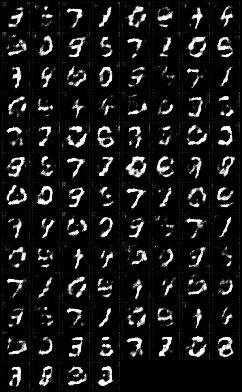

In [15]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


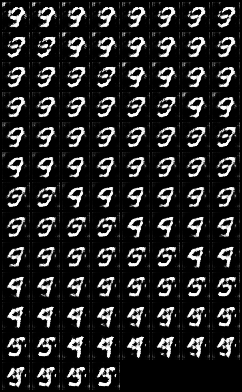

In [16]:
import io
import base64
from IPython.display import HTML

video = io.open(result_dir_2 + '/fake_images_total.gif', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

## 9. Use model to generate new sample

In [17]:
try:
    G.load_state_dict(torch.load(model_dir + '/infogan_generator.pkl'))
    D.load_state_dict(torch.load(model_dir + '/infogan_discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model restored--------



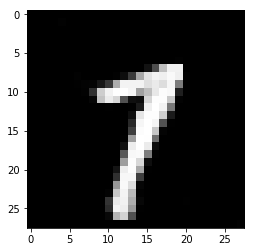

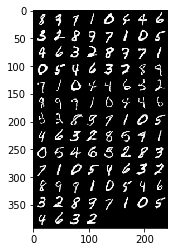

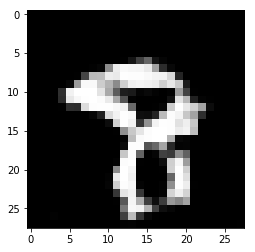

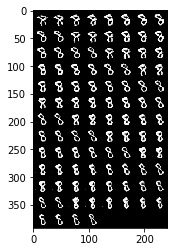

In [18]:
# 1. Style by class
sample_z = torch.zeros((sample_num, z_dim))
for i in range(10):
    sample_z[i * y_dim] = torch.rand(1, z_dim)
    for j in range(1, y_dim):
        sample_z[i * y_dim + j] = sample_z[i * y_dim]

temp = torch.zeros((10, 1))
for i in range(y_dim):
    temp[i, 0] = i
    
temp_y = torch.zeros((sample_num, 1))
for i in range(10):
    temp_y[i*y_dim:(i+1)*y_dim] = temp
    
sample_y = torch.zeros((sample_num, y_dim))
sample_y.scatter_(1, temp_y.type(torch.LongTensor), 1)
sample_c = torch.zeros((sample_num, len_continuous_code))


# 2. manipulating two continous codes
temp_z = torch.rand((1, z_dim))
sample_z2 = temp_z
for i in range(sample_num - 1):
    sample_z2 = torch.cat([sample_z2, temp_z])
    
y = np.zeros(sample_num, dtype=np.int64)
y_one_hot = np.zeros((sample_num, len_discrete_code))
y_one_hot[np.arange(sample_num), y] = 1
sample_y2 = torch.from_numpy(y_one_hot).type(torch.FloatTensor)

temp_c = torch.linspace(-1, 1, 10)
sample_c2 = torch.zeros((sample_num, 2))
for i in range(10):
    for j in range(10):
        sample_c2[i*10+j, 0] = temp_c[i]
        sample_c2[i*10+j, 1] = temp_c[j]
        
if USE_CUDA:
    sample_z = sample_z.cuda()
    sample_y = sample_y.cuda()
    sample_c = sample_c.cuda()
    sample_z2 = sample_z2.cuda()
    sample_y2 = sample_y2.cuda()
    sample_c2 = sample_c2.cuda()
    
G.eval()
fake_images = G(sample_z, sample_c, sample_y)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()

fake_images = G(sample_z2, sample_c2, sample_y2)
plt.imshow(fake_images[2].cpu().view(28, 28).data.numpy(), cmap='gray')
plt.show()

plt.imshow(make_grid(fake_images.data.view(sample_num,1,28,28)).cpu().permute(1,2,0).numpy())
plt.show()